## Install Grounding DINO 🦕 and default Weights

In [1]:
import os

# install 
HOME = os.getcwd()
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print("\n",CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

# install GDINO weights
!mkdir {HOME}/weights
%cd {HOME}/weights 
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/Users/billymazotti/github/evaluate-rec-od
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 437 (delta 153), reused 133 (delta 127), pack-reused 232
Receiving objects: 100% (437/437), 12.86 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (225/225), done.
/Users/billymazotti/github/evaluate-rec-od/GroundingDINO

 /Users/billymazotti/github/evaluate-rec-od/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/Users/billymazotti/github/evaluate-rec-od/weights


## Select Grounding DINO Weights for Evaluating 🏋️

In [2]:
# TODO: Specify weights .pth file
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"

WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/Users/billymazotti/github/evaluate-rec-od/weights/groundingdino_swint_ogc.pth ; exist: True


## Load Grounding DINO Model

In [6]:
# TODO: Specify device (e.g. cuda, mps, cpu)
DEVICE = 'mps'

%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate
model = load_model(CONFIG_PATH, WEIGHTS_PATH, device=DEVICE)

/Users/billymazotti/github/evaluate-rec-od/GroundingDINO
final text_encoder_type: bert-base-uncased


## Select Dataset to Evaluate

In [37]:
%cd {HOME}
# TODO: Specify path to the dataset
# dataset
# ---> /images
# ---> instances.json
# ---> refs.json
PATH_TO_DATASET = os.getcwd() + "/test"


PATH_TO_DATASET_IMAGES =  PATH_TO_DATASET + "/images/"
PATH_TO_DATASET_INSTANCES_FILE =   PATH_TO_DATASET + "/instances.json"
PATH_TO_DATASET_REFS_FILE =   PATH_TO_DATASET + "/refs.json"

print(f"Successfully Found {PATH_TO_DATASET}") if os.path.isdir(PATH_TO_DATASET) else print(f"Did not find {PATH_TO_DATASET}")
print(f"Successfully Found {PATH_TO_DATASET_IMAGES}") if os.path.isdir(PATH_TO_DATASET_IMAGES) else print(f"Did not find {PATH_TO_DATASET_IMAGES}")
print(f"Successfully Found {PATH_TO_DATASET_INSTANCES_FILE}") if os.path.isfile(PATH_TO_DATASET_INSTANCES_FILE) else print(f"Did not find {PATH_TO_DATASET_INSTANCES_FILE}")
print(f"Successfully Found {PATH_TO_DATASET_REFS_FILE}") if os.path.isfile(PATH_TO_DATASET_REFS_FILE) else print(f"Did not find {PATH_TO_DATASET_REFS_FILE}")


/Users/billymazotti/github/evaluate-rec-od
Successfully Found /Users/billymazotti/github/evaluate-rec-od/test
Successfully Found /Users/billymazotti/github/evaluate-rec-od/test/images/
Successfully Found /Users/billymazotti/github/evaluate-rec-od/test/instances.json
Successfully Found /Users/billymazotti/github/evaluate-rec-od/test/refs.json


# Preprocess the data

In [38]:
import json
instances_file = open(PATH_TO_DATASET_INSTANCES_FILE)
instnaces_dict = json.load(instances_file)
refs_file = open(PATH_TO_DATASET_REFS_FILE)
refs_list = json.load(refs_file)

# find mapping for image_name to annotation
image_to_annotations_map = {}
for anno_id, anno in enumerate(instnaces_dict["annotations"]):
 image_id = instnaces_dict["annotations"][anno_id]["image_id"]
 if image_id in list(image_to_annotations_map.keys()):
  image_to_annotations_map[image_id].append(anno_id)
 else:
  image_to_annotations_map[image_id] = [anno_id]


# find mapping for category it to category type
category_id_to_name_map = {}
for category in instnaces_dict["categories"]:
  category_id_to_name_map[category["id"]] = category["name"]

# create ann_id to refs index
ann_id_to_refs_index = {}
for ref_index, ref in enumerate(refs_list):
  ann_id_to_refs_index[ref['ann_id']] = ref_index

In [39]:
# RETRIEVE ALL GROUND TRUTH BOUNDING BOXES AND PHRASES FOR EACH IMAGE
import torch
import copy
from tqdm import tqdm

img_h, img_w = [instnaces_dict["images"][0]["height"],instnaces_dict["images"][0]["width"]]
images_in_dataset = list(image_to_annotations_map.keys())

# loop through all images in specified dataset
for image_id in tqdm(images_in_dataset):

  num_annotations = len(image_to_annotations_map[image_id]) # number of annotations for image

  # initialize bounding boxes and phrases
  boxes = torch.zeros((num_annotations,4))
  phrases = []

  # loop through all annotations for the image
  for bbox_index, anno_id in enumerate(image_to_annotations_map[image_id]):

    # convert pixel bounding box (xmin, ymin, w, h) to percentage bounding box (xcenter,ycenter,w,h)
    bbox_pix = instnaces_dict["annotations"][anno_id]["bbox"]
    bbox_pix_shifted = copy.deepcopy(bbox_pix)
    bbox_pix_shifted[0] += bbox_pix_shifted[2]/2
    bbox_pix_shifted[1] += bbox_pix_shifted[3]/2
    bbox_per = torch.tensor([bbox_pix_shifted[0]/img_w, bbox_pix_shifted[1]/img_h, bbox_pix_shifted[2]/img_w, bbox_pix_shifted[3]/img_h])
    boxes[bbox_index,:] = bbox_per


    phrases.append(str(instnaces_dict["annotations"][anno_id]["category_id"])) # for visualization

  logits = torch.zeros(num_annotations) # for visualization


100%|██████████| 325/325 [00:00<00:00, 3881.38it/s]


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


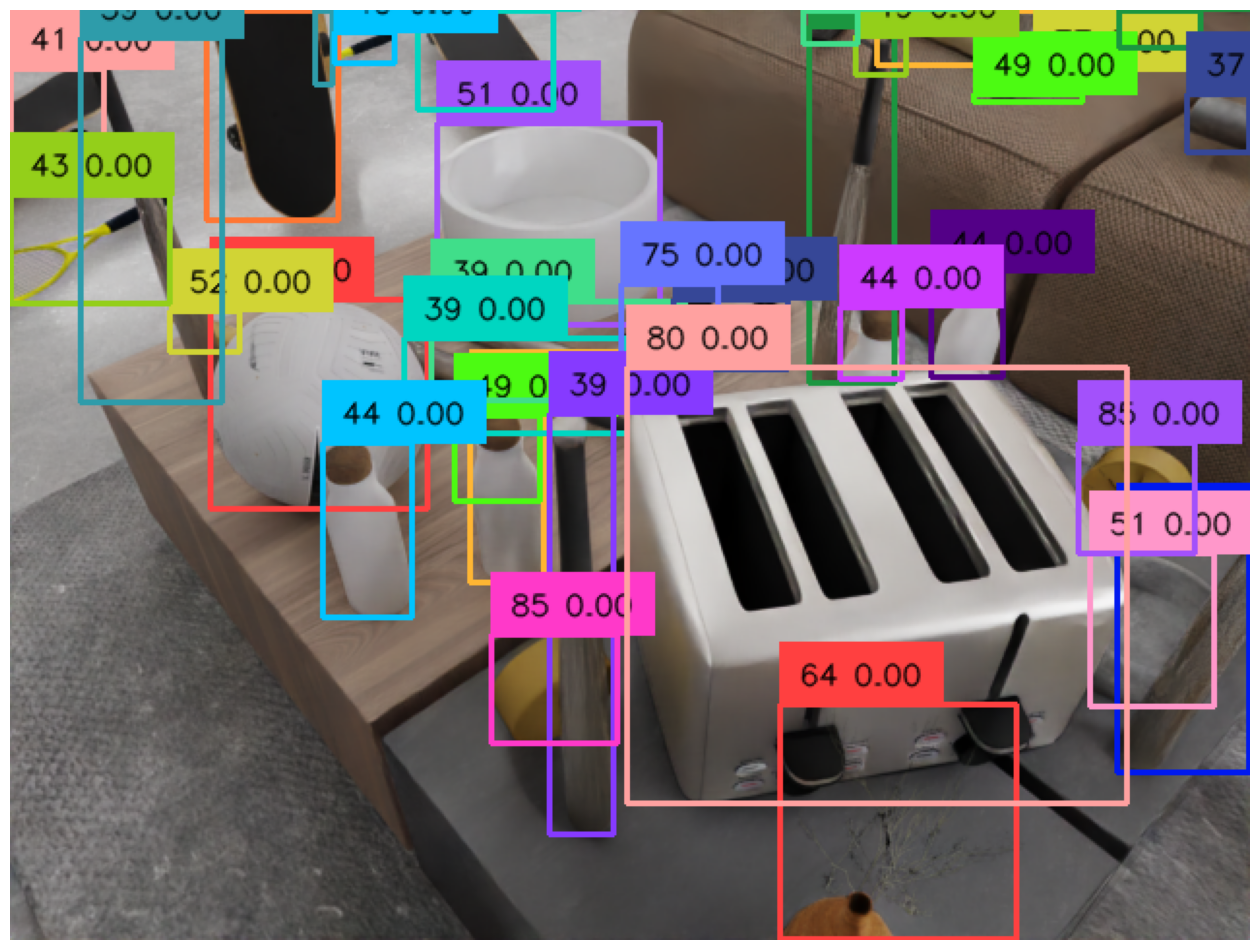

In [41]:
# VISUALIZE THE GROUND TRUTH BOUNDING BOXES AND CATEGORY ID'S FOR EACH IMAGE
import supervision as sv

IMAGE_NAME = str(image_id).zfill(6) + ".png"
IMAGE_PATH = PATH_TO_DATASET_IMAGES + IMAGE_NAME
image_source, image = load_image(IMAGE_PATH)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

  0%|          | 0/1 [00:00<?, ?it/s]FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.



Image 0 on phrase 0


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


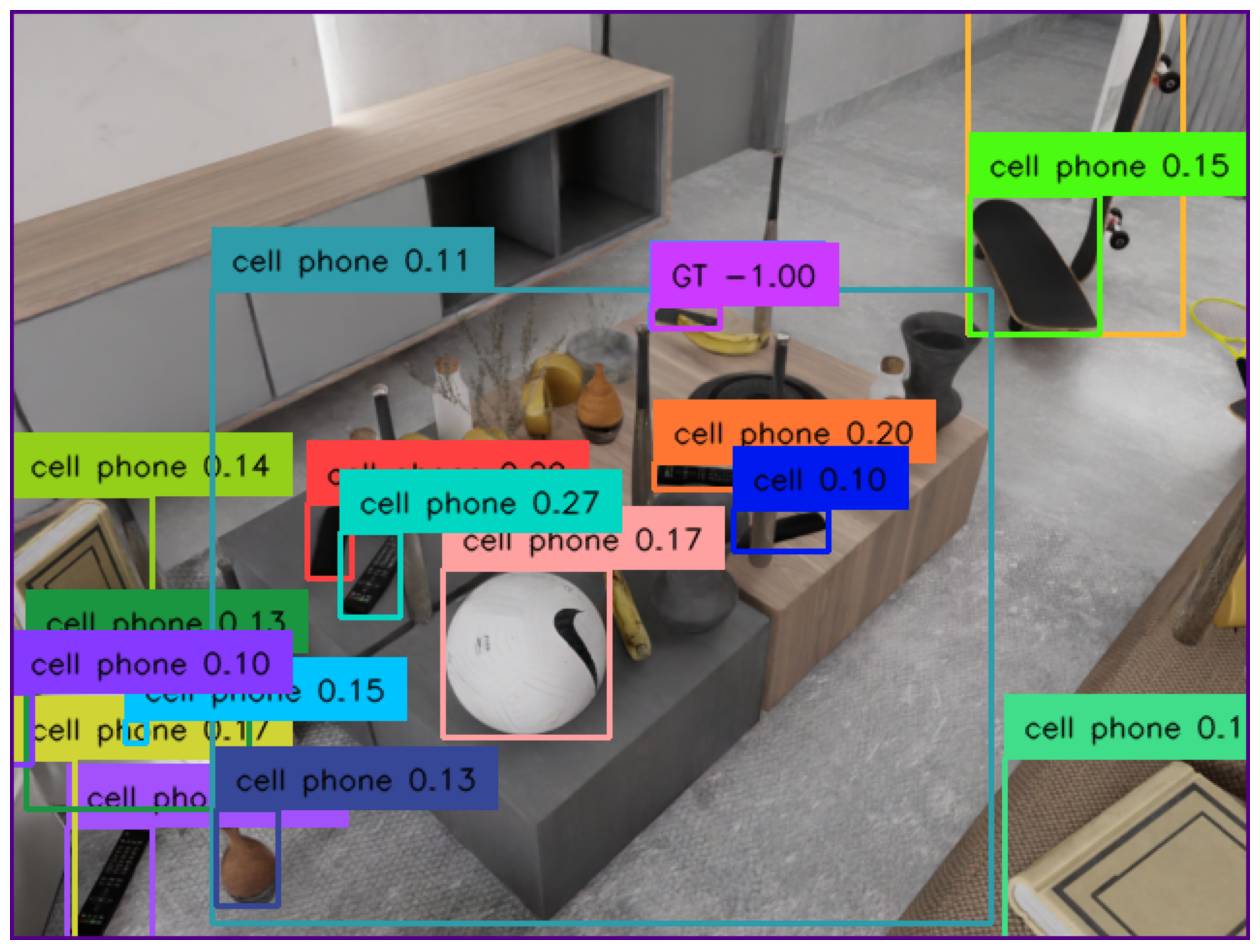


Image 0 on phrase 1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


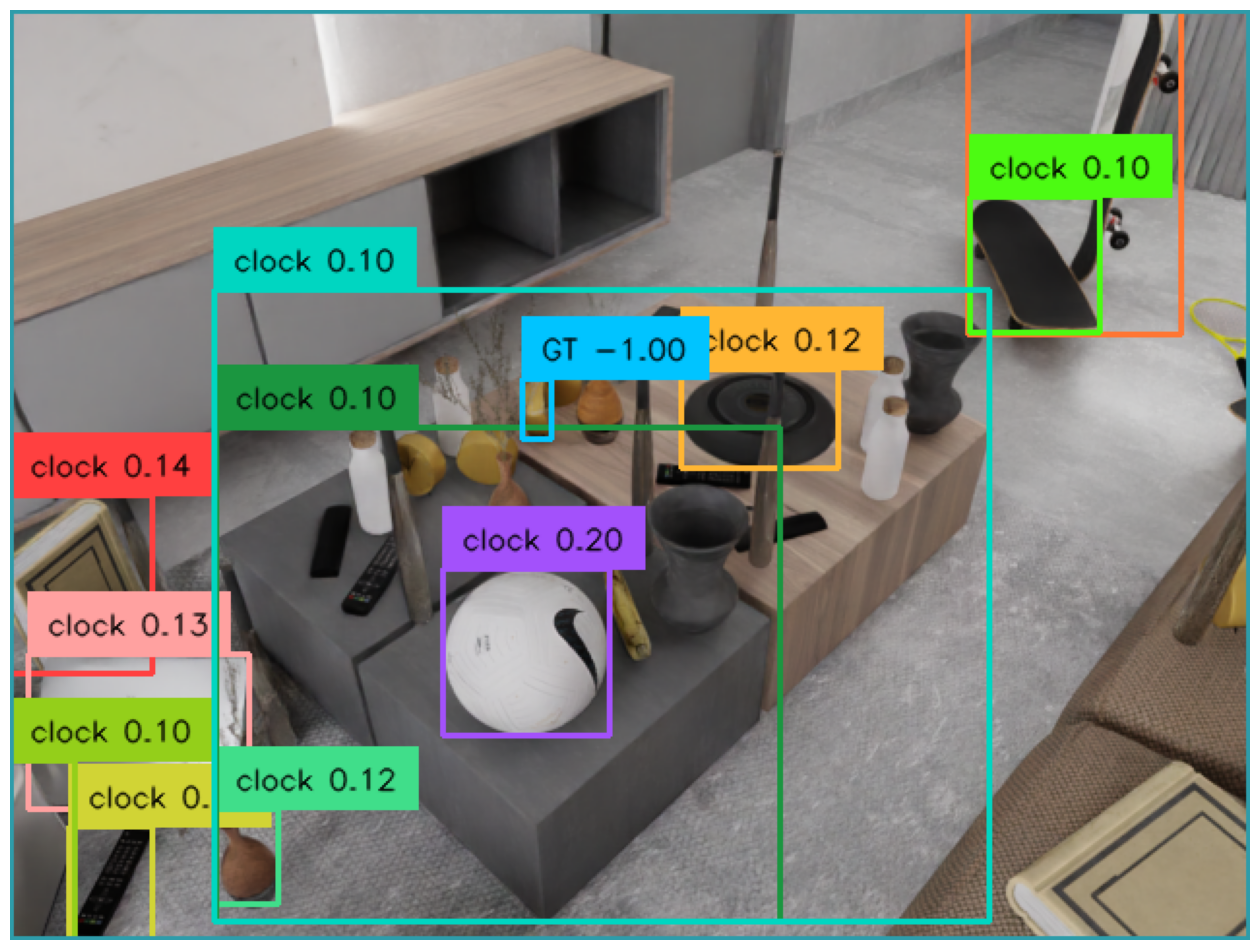

100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


In [45]:
# VISUALIZE GROUND TRUTH AND ALL PREDICTIONS FOR NUM_PHRASES phrases ON NUM_IMAGES iamges
from tqdm import tqdm
import random

NUM_IMAGES = 1
NUM_PHRASES = 2

BOX_TRESHOLD = 0.10 # 35
TEXT_TRESHOLD = 0.10  #25

img_h, img_w = [instnaces_dict["images"][0]["height"],instnaces_dict["images"][0]["width"]]
images_in_dataset = list(image_to_annotations_map.keys())

# loop through all images in specified dataset
for iamge_count, image_id in enumerate(tqdm(images_in_dataset[0:NUM_IMAGES])):

  IMAGE_NAME = str(image_id).zfill(6) + ".png"
  IMAGE_PATH = PATH_TO_DATASET_IMAGES + IMAGE_NAME

  num_annotations = len(image_to_annotations_map[image_id]) # number of annotations for image

  # loop through all ground truth bounding boxes for the image
  for bbox_index, anno_id in enumerate(image_to_annotations_map[image_id][0:NUM_PHRASES]):
    
    print(f"\nImage {iamge_count} on phrase {bbox_index}")

    # find the ground truth bounding box
    # convert pixel bounding box (xmin, ymin, w, h) to percentage bounding box (xcenter,ycenter,w,h)
    bbox_pix = instnaces_dict["annotations"][anno_id]["bbox"]
    bbox_pix_shifted = copy.deepcopy(bbox_pix)
    bbox_pix_shifted[0] += bbox_pix_shifted[2]/2
    bbox_pix_shifted[1] += bbox_pix_shifted[3]/2
    box_gt = torch.tensor([bbox_pix_shifted[0]/img_w, bbox_pix_shifted[1]/img_h, bbox_pix_shifted[2]/img_w, bbox_pix_shifted[3]/img_h])

    # choose randome annotation phrase
    anno_sentences = refs_list[anno_id]['sentences']
    num_sentences = len(anno_sentences)
    TEXT_PROMPT = anno_sentences[random.randint(0,num_sentences-1)]['sent']

    # find the predicted bounding boxes
    image_source, image = load_image(IMAGE_PATH)
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD,
        device = DEVICE
    )

    boxes = torch.vstack((boxes,box_gt))
    new = torch.tensor([-1.0])
    logits = torch.cat((logits,new))
    phrases.append("GT")

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    %matplotlib inline
    sv.plot_image(annotated_frame, (16, 16))

## Grounding DINO Demo

tensor([[0.4162, 0.6906, 0.1352, 0.1817],
        [0.3159, 0.5306, 0.0521, 0.2609],
        [0.4975, 0.6437, 0.0408, 0.1137],
        [0.8262, 0.2741, 0.1051, 0.1486],
        [0.1917, 0.9103, 0.0504, 0.1016],
        [0.8593, 0.1745, 0.1725, 0.3499],
        [0.1049, 0.5767, 0.0754, 0.2088],
        [0.0811, 0.9387, 0.0690, 0.1220],
        [0.6110, 0.4723, 0.0354, 0.2547],
        [0.2904, 0.6074, 0.0485, 0.0900],
        [0.2581, 0.5710, 0.0351, 0.0805],
        [0.5814, 0.2615, 0.0874, 0.2243],
        [0.5747, 0.3484, 0.0772, 0.0484],
        [0.6046, 0.4394, 0.1271, 0.1094],
        [0.8986, 0.1464, 0.0924, 0.2932],
        [0.5102, 0.4619, 0.0229, 0.2525],
        [0.5596, 0.5005, 0.0796, 0.0298],
        [0.6110, 0.2517, 0.0290, 0.2033]])
torch.Size([18])
18


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


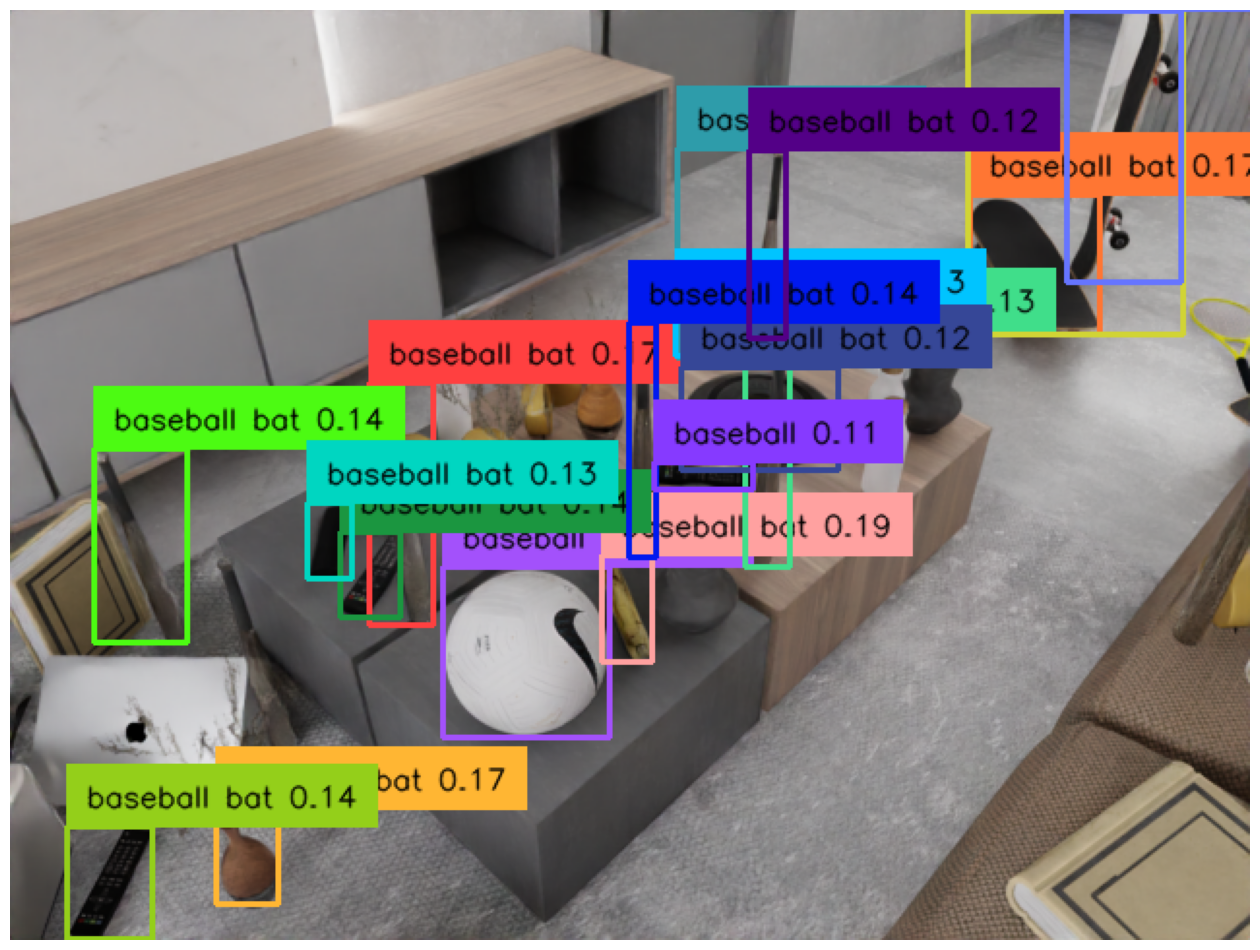

In [51]:
# INFERENCE OVER A SINGLE IMAGE
import os
import supervision as sv

# TODO: Specify image, 
IMAGE_NAME = "000006.png"
TEXT_PROMPT = "baseball bat"
BOX_TRESHOLD = 0.10 # 35
TEXT_TRESHOLD = 0.10  #25


IMAGE_PATH = os.path.join(HOME, "data",PATH_TO_DATASET_IMAGES, IMAGE_NAME)
image_source, image = load_image(IMAGE_PATH)
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device = DEVICE
)

print("="*30)
print(boxes)
print(logits.shape)
print(len(phrases))
print("="*30)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [ ]:
import os
import supervision as sv

IMAGE_NAME = "dog-3.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "leftmost chair"
BOX_TRESHOLD = 0.15   # 15
TEXT_TRESHOLD = 0.15  # 15

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Grounding DINO with Roboflow Dataset